## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle5 as pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]
def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs
def get_cities_trajectories(split="train"):
    inputs_cities = None
    outputs_cities = None
    for city in cities:
        if split=="train":
            f_in = ROOT_PATH + split + "/" + city + "_inputs"
            inputs = pickle.load(open(f_in, "rb"))
            n = len(inputs)
            inputs = np.asarray(inputs)[:int(n * 0.8)]
            f_out = ROOT_PATH + split + "/" + city + "_outputs"
            outputs = pickle.load(open(f_out, "rb"))
            outputs = np.asarray(outputs)[:int(n * 0.8)]
        elif split == 'val':
            f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
            inputs = pickle.load(open(f_in, "rb"))
            n = len(inputs)
            inputs = np.asarray(inputs)[int(n * 0.8):]

            f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
            outputs = pickle.load(open(f_out, "rb"))
            outputs = np.asarray(outputs)[int(n * 0.8):] 
        else:
            f_in = ROOT_PATH + split + "/" + city + "_inputs"
            inputs = pickle.load(open(f_in, "rb"))
            n = len(inputs)
            inputs = np.asarray(inputs)
            outputs= None
        if inputs_cities is None:
            inputs_cities =inputs
        else:
            i = (np.concatenate((inputs_cities, inputs), axis=0))
            inputs_cities = i
        if outputs_cities is None:
            outputs_cities = outputs
        else:
            o = np.concatenate((outputs_cities, outputs), axis=0)
            outputs_cities= o
    return inputs_cities, outputs_cities  


class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_cities_trajectories(split=split)
        global_mean = np.mean(self.inputs, axis = (0,1), keepdims = True)
        global_std = np.std(np.sqrt(self.inputs[:, :, 0]**2 + self.inputs[:, :, 0]**2))
        print(global_mean)
        print(global_std)
        #if split == "train":
            #self.inputs = (self.inputs - global_mean)/global_std
            
            #self.outputs = (self.outputs - global_mean)/global_std
        #else:
            #self.inputs = (self.inputs - global_mean)/global_std
            #self.outputs = (self.outputs - global_mean)/global_std
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'miami' 
split = 'train'
train_dataset  = ArgoverseDataset(split = split)

[[[2791.70427041 1064.76260345]]]
4100.326502228328


In [3]:
val_dataset = ArgoverseDataset(split = 'val')


[[[2779.01081344 1063.5660105 ]]]
4124.162302888706


In [4]:
print(len(val_dataset))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

40765
cuda:0


## Create a DataLoader class for training

batch_sz = 16  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [5]:
batch_sz = 108# batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [6]:
from torch import nn, optim

class mlp(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(100, 108),
            nn.LeakyReLU(),
            nn.Linear(108, 108),
            nn.LeakyReLU(),
            nn.Linear(108, 108),
            nn.LeakyReLU(),
            nn.Linear(108, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.mlp(x)
        x = x.reshape(-1, 60, 2)
        return x


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pred = mlp()
pred.to(device)
#opt = optim.LBFGS( pred.parameters(),lr=.005)
opt = optim.Adam(pred.parameters(), lr=.00001,weight_decay=0.9)
loss_func = nn.MSELoss()

val_loader = DataLoader(val_dataset,batch_size=batch_sz)
inputs, outputs = get_cities_trajectories(split="train")
val_loss = 0



In [20]:
train_loss_values = [0.0] * 269
val_loss_values = [0.0] * 269
for epoch in range(269):
    
    total_loss = 0
    val_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        
        inp, out = sample_batch
        inp = inp.to(device)
        out = out.to(device).float()
        preds = pred(inp)
        opt.zero_grad()
        loss = loss_func(preds,out)
        loss.backward()
        
        opt.step()
        
        total_loss += loss.item()
    train_loss_values[epoch] = total_loss    
    print('epoch {} loss: {}'.format(epoch, total_loss))
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        inp, out = inp.to(device), out.to(device)
       # print(out.size())
        preds = pred(inp)
        #preds = (preds * gs ) + gm
        loss = loss_func(preds,out)
        val_loss += loss.item()
    val_loss_values[epoch] = val_loss
    print('loss: {}'.format(val_loss))

epoch 0 loss: 1376681.847869873
loss: 368423.44288511935
epoch 1 loss: 1369984.3684692383
loss: 365512.8472804532
epoch 2 loss: 1363675.5915527344
loss: 362999.9050180591
epoch 3 loss: 1357679.3678588867
loss: 361189.2344038525
epoch 4 loss: 1350409.1438293457
loss: 358373.6809436027
epoch 5 loss: 1344733.4536743164
loss: 356218.7345428087
epoch 6 loss: 1338456.9952087402
loss: 354415.3251266225
epoch 7 loss: 1332554.1987609863
loss: 352034.3501386175
epoch 8 loss: 1326130.7788391113
loss: 350795.61950470455
epoch 9 loss: 1320485.668121338
loss: 348192.166994737
epoch 10 loss: 1314480.5388183594
loss: 345776.7591107095
epoch 11 loss: 1308462.6363220215
loss: 344301.2076714501
epoch 12 loss: 1302872.6954040527
loss: 341737.2568247453
epoch 13 loss: 1296801.8770751953
loss: 339951.4929602461
epoch 14 loss: 1290775.6351623535
loss: 337961.16495614365
epoch 15 loss: 1285084.3891906738
loss: 336422.68416428013
epoch 16 loss: 1278995.090209961
loss: 335126.54295999376
epoch 17 loss: 1273172.

loss: 86822.08776007988
epoch 142 loss: 314284.97051239014
loss: 87056.85499634795
epoch 143 loss: 310320.82093811035
loss: 85776.9559337852
epoch 144 loss: 298082.24909210205
loss: 82528.21809091157
epoch 145 loss: 291878.77767181396
loss: 82773.29440813247
epoch 146 loss: 288286.89892578125
loss: 81282.89595023425
epoch 147 loss: 285385.79608154297
loss: 80580.35543437951
epoch 148 loss: 282146.9130859375
loss: 79371.40980667395
epoch 149 loss: 278747.19929504395
loss: 77590.11154113218
epoch 150 loss: 276529.50311279297
loss: 76893.63337066231
epoch 151 loss: 272886.2613067627
loss: 77462.96486667065
epoch 152 loss: 269433.8271560669
loss: 76661.89205559164
epoch 153 loss: 266971.0348510742
loss: 74830.06671449676
epoch 154 loss: 264891.66954803467
loss: 75565.28192857585
epoch 155 loss: 262415.6491394043
loss: 74254.27235696581
epoch 156 loss: 260861.39010620117
loss: 73198.86534964405
epoch 157 loss: 258574.45960235596
loss: 72749.61847397062
epoch 158 loss: 257193.23091888428
los

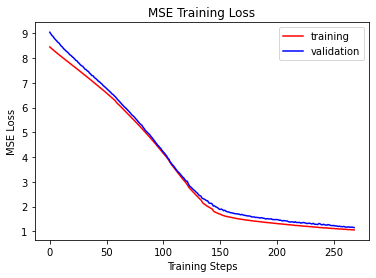

In [38]:
import matplotlib.pyplot as plt
v = [x / (len(val_dataset)) for x in val_loss_values]
t = [x / (len(train_dataset)) for x in train_loss_values]
plt.plot(range(269), t, 'r', label='training')
plt.plot(range(269), v, 'b', label='validation')
plt.title('MSE Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

## Sample a batch of data and visualize 

3.5.1


C:\Users\ajsla\anaconda3\envs\pytorch_p37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


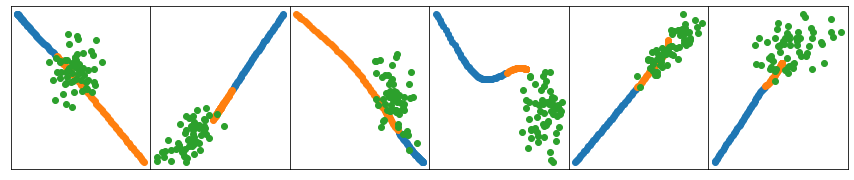

In [43]:
def get_traj_pred(test_traj_in):
    test_data = torch.tensor(test_traj_in).to(device)
    test_preds = pred(test_data.float())
    #est_preds.detach().numpy()
    return test_preds.cpu().detach().numpy()


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    pout = get_traj_pred(inp)
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,6, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(6):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        axs[i].scatter(pout[i,:,0], pout[i,:,1])
        


for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
 
    show_sample_batch(sample_batch)
    break

In [38]:
num_pred_steps=60
all_preds = np.zeros(shape=(0, num_pred_steps * 2))
city_col = np.array([])

for city_name in cities:

    print("Processing city", city_name)
    
    test_traj_in, test_traj_out = get_city_trajectories(city=city_name, split="test")
    print(test_traj_in.shape)
    
    test_pred_arr = get_traj_pred(test_traj_in)
    print(test_pred_arr.shape)
    
    test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_traj_in.shape[0], num_pred_steps * 2))
    print(test_pred_arr_reshaped.shape)

    all_preds = np.r_[all_preds, test_pred_arr_reshaped]
    city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]

Processing city austin
(6325, 50, 2)
(6325, 60, 2)
(6325, 120)
Processing city miami
(7971, 50, 2)
(7971, 60, 2)
(7971, 120)
Processing city pittsburgh
(6361, 50, 2)
(6361, 60, 2)
(6361, 120)
Processing city dearborn
(3671, 50, 2)
(3671, 60, 2)
(3671, 120)
Processing city washington-dc
(3829, 50, 2)
(3829, 60, 2)
(3829, 120)
Processing city palo-alto
(1686, 50, 2)
(1686, 60, 2)
(1686, 120)


In [39]:
import pandas as pd
sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
sub_df.to_csv('mlplast.csv', index=None)

In [40]:
sample_sub = pd.read_csv('mlplast.csv')
sample_sub.tail()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
29838,1681_palo-alto,-1383.680786,-489.537109,-1385.547852,-489.713898,-1383.920776,-490.203461,-1385.380981,-490.185791,-1385.714844,...,-1405.630127,-498.192352,-1409.341553,-499.270050,-1403.954102,-496.826050,-1409.085205,-498.493317,-1405.751343,-498.395874
29839,1682_palo-alto,122.629471,-10.010162,125.069748,-11.620230,125.307785,-9.219109,125.052856,-11.121703,126.294273,...,131.136581,-3.340473,126.438576,-5.382370,129.516449,-4.006420,129.325027,-4.428313,127.140999,-2.472411
29840,1683_palo-alto,-1441.717773,2158.276855,-1443.122192,2157.437988,-1444.265503,2157.540283,-1450.064819,2156.961182,-1437.574707,...,-1447.757690,2159.341797,-1443.009033,2163.795898,-1444.367310,2156.014893,-1449.048950,2156.069580,-1444.887329,2158.684814
29841,1684_palo-alto,1075.180908,1403.052002,1072.154175,1406.686890,1071.777222,1404.558472,1077.145020,1402.625000,1082.693481,...,1098.123779,1414.283813,1098.343872,1411.583862,1095.932495,1417.898682,1094.261597,1416.074341,1098.073242,1414.664673
29842,1685_palo-alto,-2.194973,392.667694,-10.878397,398.609894,-9.412887,392.179474,-6.894555,397.255157,4.007752,...,14.410361,388.260925,28.044476,396.095978,16.343666,393.032745,17.152117,390.771698,32.906712,394.276428
